# Virus on a Network Approximate Bayesian Computation

This tutorial will cover the use of Approximate Bayesian Computation (ABC) on Virus on a Network for Bayesian calibration of stochastic computer simulation models. 

Bayesian calibration of computer simulation models is a method to update uncertain model parameters using observed data and prior knowledge, producing a posterior distribution that reflects parameter uncertainty. It treats the simulator as a probabilistic function, often incorporating a discrepancy term to account for model–reality differences. This approach allows quantified predictions and uncertainty propagation in the model outputs. [A useful text on Bayesian calibration may be found here](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/1467-9868.00294). 

[A useful link covering Bayesian calibration for agent-based models may be found here.](https://www.sciencedirect.com/science/article/pii/S0304380015002173)

# Imports

We will first import all required dependencies and specify our constants.

In [1]:
from voan import VirusOnNetwork
import pandas as pd
import networkx as nx

from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)
from calisim.abc import (
	ApproximateBayesianComputationMethod,
	ApproximateBayesianComputationMethodModel,
)
import numpy as np
from calisim.statistics import L2Norm

N_DAYS = 30
NUM_NODES = 250
AVG_NODE_DEGREE = 3
INITIAL_OUTBREAK_SIZE = 20
VIRUS_CHECK_FREQUENCY = 0.4

reference_virus_spread_chance=0.1
reference_recovery_chance=0.3
reference_gain_resistance_chance=0.5

# Calibration procedure

## Bayesian calibration

[We will use Approximate Bayesian Computation (ABC) Sequential Monte Carlo to calibrate the model](https://academic.oup.com/book/54037/chapter-abstract/422208917?redirectedFrom=fulltext). ABC aims to minimise the discrepancy between observed and simulated data up to a tolerance threshold (epsilon). Larger values of epsilon will result in faster model calibration with fewer rejections of the forward model outputs but less precise estimates. Smaller values of epsilon will result in slower model calibration with more rejections of the forward model outputs but more precise estimates.

For this exercise, there are three parameters of interest within Virus on a Network: 

- **virus_spread_chance**: The probability of infection.
- **recovery_chance**: The probability of recovery.
- **gain_resistance_chance**:  The probability of gaining disease resistance.

# Reference simulation

We will execute a reference simulation where the ground-truth parameters are already known.

```python
reference_virus_spread_chance=0.1
reference_recovery_chance=0.3
reference_gain_resistance_chance=0.5
```

In [3]:
model = VirusOnNetwork(
    num_nodes = NUM_NODES,
    avg_node_degree = AVG_NODE_DEGREE,
    initial_outbreak_size = INITIAL_OUTBREAK_SIZE,
    virus_spread_chance = reference_virus_spread_chance,
    virus_check_frequency = VIRUS_CHECK_FREQUENCY,
    recovery_chance = reference_recovery_chance,
    gain_resistance_chance = reference_gain_resistance_chance,
)

for _ in range(N_DAYS):
    model.step()
    
reference_state_df = model.datacollector.get_model_vars_dataframe()
reference_G = model.G
reference_state_df

,Infected,Susceptible,Resistant,R over S,Effect R,Contact R-Naught,Proxy Contact R-Naught
0,20,230,0,0.000000,0.000000,0.000000,0.000000
1,23,226,1,0.004425,1.000000,1.017699,0.508850
2,24,221,5,0.022624,1.000000,1.040724,0.686141
3,30,214,6,0.028037,1.428571,1.535381,0.898451
4,31,211,8,0.037915,1.000000,1.090047,0.936770
5,37,205,8,0.039024,1.000000,1.121951,0.967634
6,40,197,13,0.065990,1.222222,1.426960,1.033252
7,37,196,17,0.086735,1.000000,1.173469,1.050779
8,38,191,21,0.109948,1.125000,1.354712,1.084549
9,38,191,21,0.109948,1.000000,1.204188,1.096513


## Curse of dimensionality

ABC struggles with the curse of dimensionality with respect to the size of the simulation model outputs. 

When the observed data are high-dimensional, directly comparing simulated and observed datasets becomes increasingly unlikely to produce close matches, causing acceptance rates to plummet. To mitigate this, ABC relies on summary statistics that compress the data into lower-dimensional, informative representations. By focusing on key features rather than the full dataset, summary statistics reduce the effective dimensionality, making it feasible to identify parameter values that generate data consistent with observations. Without such dimensionality reduction, ABC can become computationally prohibitive and practically ineffective for large or complex outputs.

We will construct a vector of day-30 summary statistics from our reference simulation using both epidemiological quantities and contact network metrics.

In [6]:
def get_statistics(state_df, G):
    statistic_names = ["Effect R", "Contact R-Naught", "Proxy Contact R-Naught"]
    statistic_values = [
        state_df.tail(1)[n].item()
        for n in statistic_names
    ]
    
    network_metrics = ["density", "number_of_edges", "average_clustering"]
    for m in network_metrics:
        network_func = getattr(nx, m)
        statistic_values.append(
            network_func(G)
        )
        
    statistic_names += network_metrics
    statistics_df = pd.DataFrame({
        "statistic_name": statistic_names,
        "statistic_value": statistic_values
    })
    return statistics_df
     	 	
reference_statistics_df = get_statistics(reference_state_df, reference_G)
reference_statistics_df

,statistic_name,statistic_value
0,Effect R,1.000000
1,Contact R-Naught,2.129630
2,Proxy Contact R-Naught,1.559593
3,density,0.012016
4,number_of_edges,374.000000
5,average_clustering,0.002190


We first construct the parameter specification for Bayesian calibration. As we are going Bayesian, we can specify more complex probability distributions than the uniform distribution. In this example, we will use truncated normal distributions for our parameter specifications.

We specify both the location and scale, alongside the lower and upper bounds for the truncated normal distributions.

In [8]:
parameter_spec = ParameterSpecification(
	parameters=[
		DistributionModel(
			name="virus_spread_chance",
			distribution_name="truncnorm",
			distribution_args=[(0 - 0.1) / 0.02, (1 - 0.1) / 0.02],
            distribution_kwargs=dict(loc=0.1, scale=0.02),
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="recovery_chance",
			distribution_name="truncnorm",
			distribution_args=[(0 - 0.3) / 0.05, (1 - 0.3) / 0.05],
            distribution_kwargs=dict(loc=0.3, scale=0.05),
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="gain_resistance_chance",
			distribution_name="truncnorm",
			distribution_args=[(0 - 0.5) / 0.1, (1 - 0.5) / 0.1],
            distribution_kwargs=dict(loc=0.5, scale=0.1),
			data_type=ParameterDataType.CONTINUOUS,
		),
	]
)

Rather than using a metric such as mean squared error, ABC instead requires the use of proper distance metrics. Hence, we will use the L2 norm to quantify the discrepancy between the observed and simulated data.

In [9]:
def abc_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    model = VirusOnNetwork(
        num_nodes = NUM_NODES,
        avg_node_degree = AVG_NODE_DEGREE,
        initial_outbreak_size = INITIAL_OUTBREAK_SIZE,
        virus_spread_chance = parameters["virus_spread_chance"],
        virus_check_frequency = VIRUS_CHECK_FREQUENCY,
        recovery_chance = parameters["recovery_chance"],
        gain_resistance_chance = parameters["gain_resistance_chance"],
    )
    
    for _ in range(N_DAYS):
        model.step()
    
    state_df = model.datacollector.get_model_vars_dataframe()
    G = model.G
    statistics_df = get_statistics(state_df, G)

    simulated_data = statistics_df.statistic_value.values
    metric = L2Norm()
    discrepancy = metric.calculate(observed_data, simulated_data)
    return discrepancy

[We will use Approximate Bayesian Computation (ABC) Sequential Monte Carlo to calibrate the model](https://academic.oup.com/book/54037/chapter-abstract/422208917?redirectedFrom=fulltext). ABC aims to minimise the discrepancy between observed and simulated data up to a tolerance threshold (epsilon). Larger values of epsilon will result in faster model calibration with fewer rejections of the forward model outputs but less precise estimates. Smaller values of epsilon will result in slower model calibration with more rejections of the forward model outputs but more precise estimates.

ABC.History INFO: Start <ABCSMC id=1, start_time=2025-10-28 14:17:09>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.40046988e+01.
ABC INFO: Accepted: 25 / 41 = 6.0976e-01, ESS: 2.5000e+01.
ABC.Adaptation INFO: Change nr particles 25 -> 10
ABC INFO: Stop: Total simulations budget.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:07.962012, end_time=2025-10-28 14:17:17>


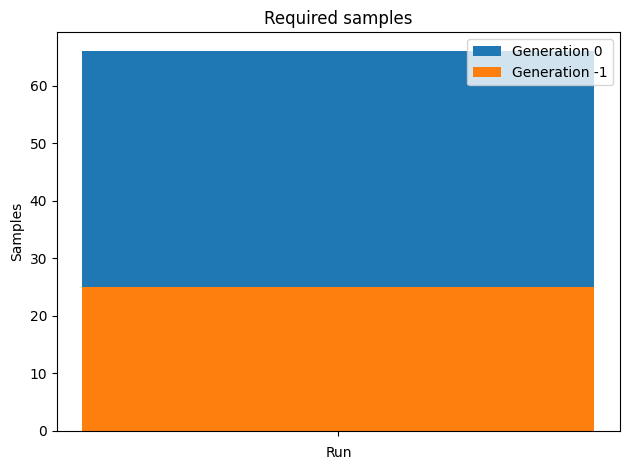

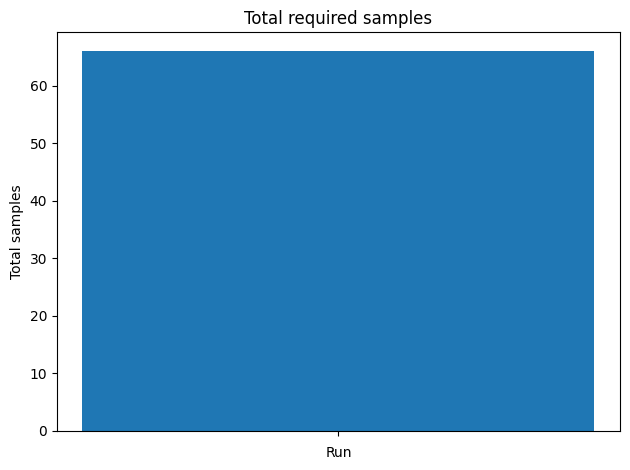

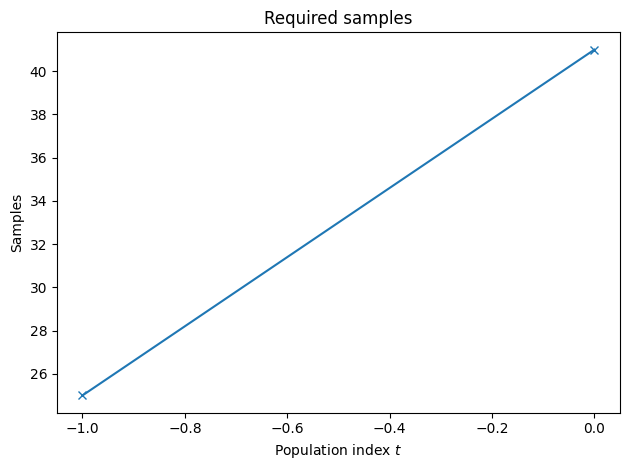

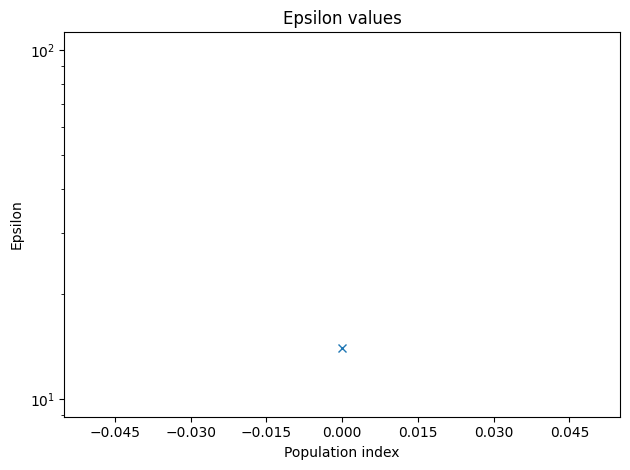

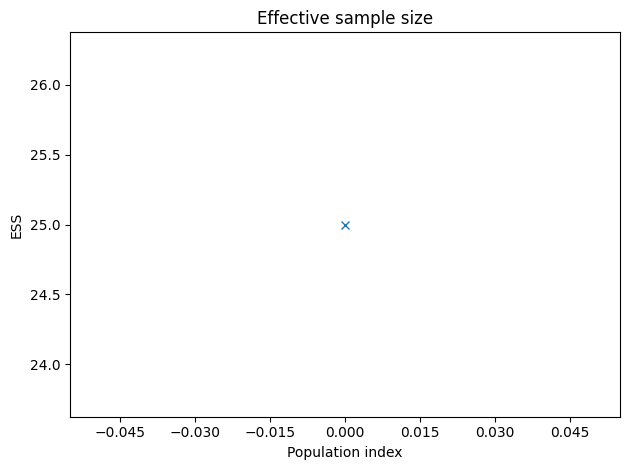

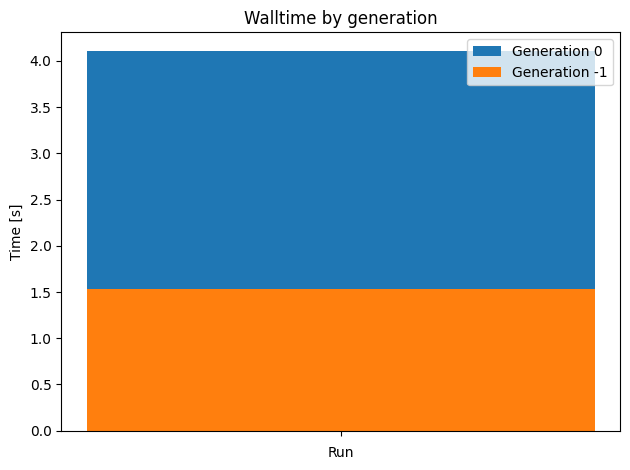

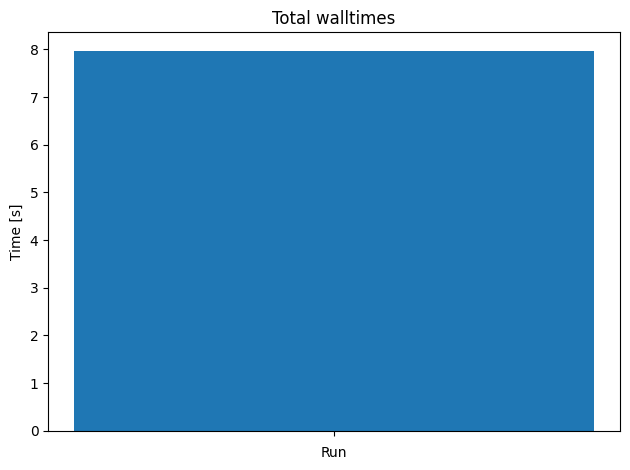

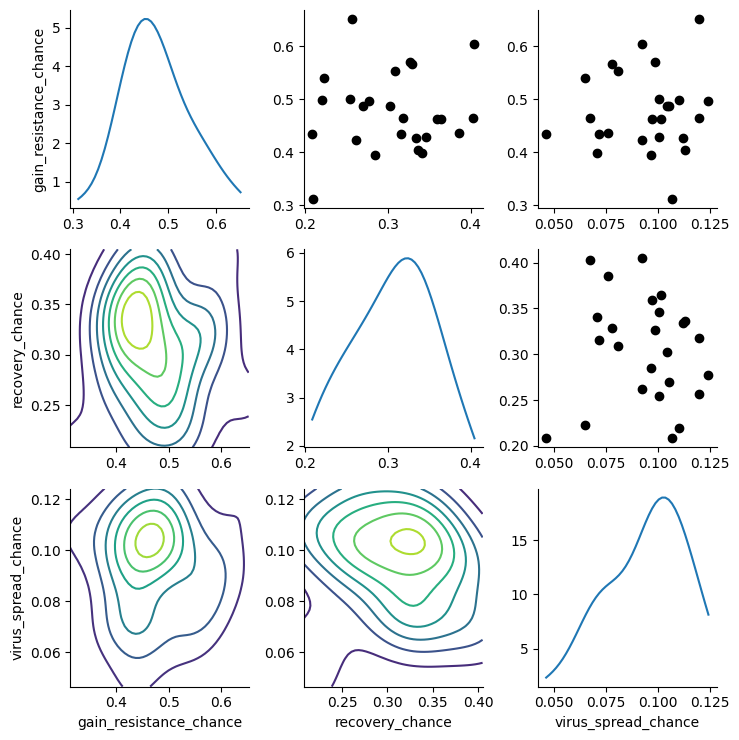

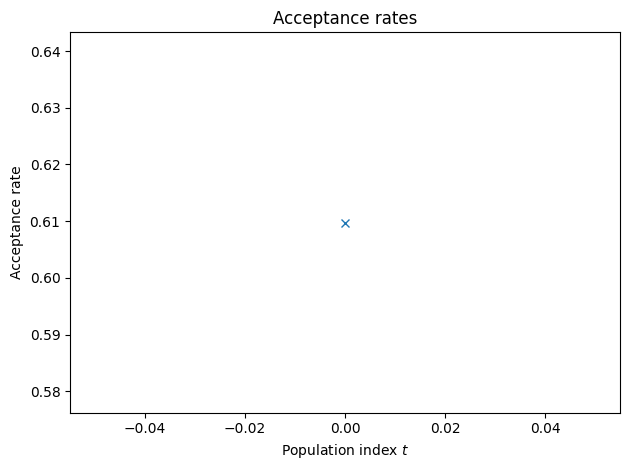

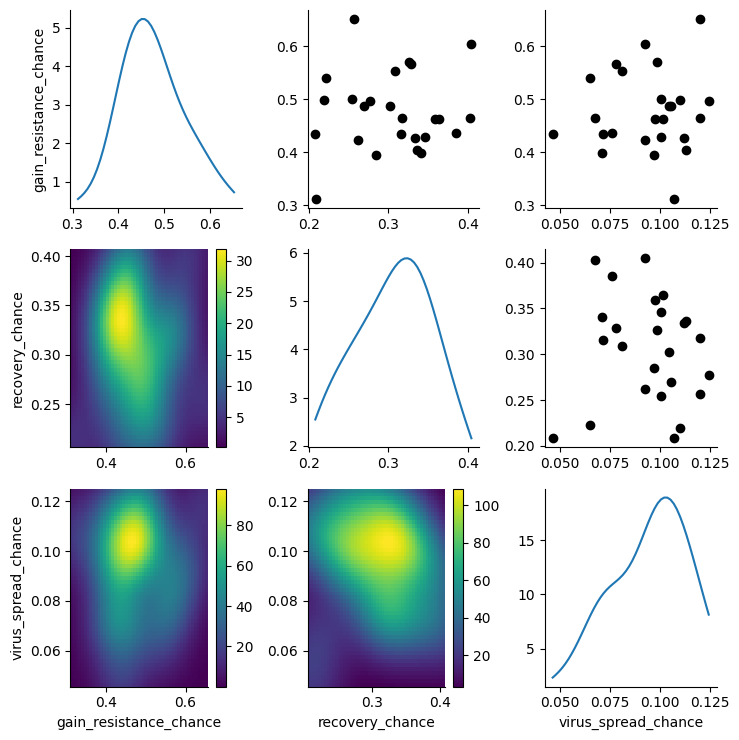

In [10]:
specification = ApproximateBayesianComputationMethodModel(
	experiment_name="pyabc_approximate_bayesian_computation",
	parameter_spec=parameter_spec,
	observed_data=reference_statistics_df.statistic_value.values,
	n_init=25,
	walltime=3,  # minutes
	epsilon=10,
    output_labels=["Diffusion Dynamics and Contact Network Structure Discrepancy"],
	n_bootstrap=25,
	min_population_size=25,
	verbose=True,
	batched=False,
    random_seed=100,
	method_kwargs=dict(
		max_total_nr_simulations=30, max_nr_populations=25, min_acceptance_rate=0.0
	),
)

calibrator = ApproximateBayesianComputationMethod(
	calibration_func=abc_func, specification=specification, engine="pyabc"
)

calibrator.specify().execute().analyze()

In [11]:
abc_df = pd.DataFrame({
    "parameter_name": [ 
        model.name
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "parameter_estimate": [ 
        model.estimate
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "parameter_uncertainty": [ 
        model.uncertainty
        for model in calibrator.get_parameter_estimates().estimates
    ],
})
abc_df

,parameter_name,parameter_estimate,parameter_uncertainty
0,gain_resistance_chance,0.476520,0.074879
1,recovery_chance,0.305456,0.057953
2,virus_spread_chance,0.094106,0.019730


We can see that Bayesian calibration provides a measure of uncertainty around the parameter estimates (the posterior mean and standard deviation). We can also refer to the ground truth values for the reference simulation.

```python
reference_virus_spread_chance=0.1
reference_recovery_chance=0.3
reference_gain_resistance_chance=0.5
```

An exercise for the interested reader would be experiment with the number of samples taken by our ABC algorithm and also try changing our parameter specification, Currently, the bounds are very tight...you could say we're "cheating" a bit.